In [19]:
# !pip install keras
# !pip install keras_utils
# !pip install plot_model

import os, sys 
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_theme()
sns.reset_orig()
from PIL import Image

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, merge  
from keras.layers import InputLayer, UpSampling2D, Concatenate, Reshape, Embedding, dot
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
# import keras_utils
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from scipy import spatial
from scipy.spatial import distance

import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans
import random
#from google.colab import drive
#drive.mount('/content/drive')

In [20]:

salida= 3

base_dir = '/home/felipe/Documentos/tesis/espectogramas_entrenamiento'
train_test_split = 0.625
no_of_files_in_each_class = 14 # tomo una muestra de N imagenes por clase
# 50 train; 30 test

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
folder_list.sort()
print(len(folder_list), "clases para construir el modelo")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name)) #una lista con los archivos de ese folder
    random.shuffle(files_list)  #randomizo
    temp=[] #va a hacer una lista de temp para cada folder
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x)) #en cada elemento del folder, agrega a temp
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('L').resize((300, 150))).reshape(300,150,1)) #¿por que se les cambia el tamaño?
        y.append(y_label)
    y_label+=1
    cat_list.append(np.asarray(temp))

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
#print('X, Y shape',x.shape, y.shape, cat_list.shape)        

train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'clases para el entrenamiento, y', test_size, ' clases para validación')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape de los datos de entrenamiento :',x_train.shape, 'y', y_train.shape, cat_train.shape)
print('X&Y shape de los datos de validación :' , x_val.shape, 'y', y_val.shape, cat_test.shape)

def get_batch(batch_size):    
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    # armamos un vector de batch_size de ceros y unos, mezclados. TAMANOS
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 300, 150,1)))
    batch_x.append(np.zeros((batch_size, 300, 150,1)))

    for i in range(0, batch_size):        
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        # If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
            batch_y[i] = 1 #agregado en esta nueva versión de Gonza/Gabo
        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            # print(temp_list)
            # print('1:',batch_x[0][i].shape)
            # print('2:',temp_x[np.random.choice(temp_list)].shape)
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            batch_y[i] = 0 #agregado en esta nueva versión de Gonza/Gabo
    return(batch_x, batch_y)

def nway_one_shot_val(model, n_way, n_val):    
#    temp_x = x_val
#    temp_cat_list = cat_test
#    batch_x=[]
#    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size, len(folder_list), n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 300, 150,1)))
        temp.append(np.zeros((n_way, 300, 150,1)))
        for k in range(0, n_way):
            temp[0][k] = x[j]            
            if k==0:
                # print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                # print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = model.predict(temp)
        result = result.flatten().tolist()
        # print(result)
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    # print(temp[0].shape)
    accuracy = (n_correct*100)/n_val
    return accuracy

def nway_one_shot_train(model, n_way, n_val):    
#    temp_x = x_val
#    temp_cat_list = cat_test
#    batch_x=[]
#    x_0_choice=[]
    n_correct = 0   
    class_list = np.random.randint(0, train_size, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 300, 150,1)))
        temp.append(np.zeros((n_way, 300, 150,1)))
        for k in range(0, n_way):
            temp[0][k] = x[j]            
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:train_size].flatten()))]

        result = model.predict(temp)
        result = result.flatten().tolist()
        # print(result)
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    # print(temp[0].shape)
    accuracy = (n_correct*100)/n_val
    return accuracy

def contrastive_loss(y, preds, margin=2):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

batch_size = 128#128
batch_x, batch_y = get_batch(batch_size)
# batch_x is a list of 2 elements.
# Each element contains a number #batch_size sonograms
# batch_y is 0 is those elements are from the same class

#np.random.randint(train_size, len(folder_list), n_val)

#Building a sequential model
input_shape=(300, 150, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

#kernel_initializer=W_init
#bias_initializer=b_init

model = keras.models.Sequential([ 
    keras.layers.Conv2D(32, (5,5),strides=2, activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.05),
    
    keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.05),
    
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(1,2),
    keras.layers.Dropout(0.05),
    
    keras.layers.Conv2D(512, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    
    keras.layers.Dense(1024, activation='relu', kernel_initializer=W_init, bias_initializer=b_init,kernel_regularizer=l2(2e-4)),
    # keras.layers.Dense(32, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init,kernel_regularizer=l2(1e-3)),
    keras.layers.Dense(salida, activation='linear', kernel_initializer=W_init, bias_initializer=b_init)
])#aca se pone la dimensionalidad del espacio de salida

encoded_l = model(left_input)
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_layer = Lambda(lambda tensors:tensors[0] - tensors[1])

# subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
L1_distance = L1_layer([encoded_l, encoded_r])

vector_norm = keras.layers.dot([L1_distance, L1_distance], axes=1)
# final_layer = Lambda(lambda tensors:K.log(tensors))(vector_norm)

# Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid', use_bias=False)(vector_norm)

siamese_net = Model([left_input, right_input], vector_norm)  # modelo completo
# distance_net = Model([left_input, right_input], vector_norm)
encoder = Model([left_input],encoded_l) #codificador para emplear la red

optimizer= Adam(0.0001)

# siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer)

# plot_model.plot_model(siamese_net, show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(model)
# model.summary()

5 clases para construir el modelo
3 clases para el entrenamiento, y 2  clases para validación
X&Y shape de los datos de entrenamiento : (42, 300, 150, 1) y (42,) (3, 14)
X&Y shape de los datos de validación : (28, 300, 150, 1) y (28,) (2, 14)


Epoch: 1 , Loss: 2.2065441608428955
Epoch: 2 , Loss: 2.2060084342956543
Epoch: 3 , Loss: 2.205406904220581
Epoch: 4 , Loss: 2.2040185928344727
Epoch: 5 , Loss: 2.2028720378875732
Epoch: 6 , Loss: 2.2024309635162354
Epoch: 7 , Loss: 2.2021656036376953
Epoch: 8 , Loss: 2.20017671585083
Epoch: 9 , Loss: 2.1976318359375
Epoch: 10 , Loss: 2.1982767581939697
Epoch: 11 , Loss: 2.197410821914673
Epoch: 12 , Loss: 2.19649600982666
Epoch: 13 , Loss: 2.1956934928894043
Epoch: 14 , Loss: 2.1931068897247314
Epoch: 15 , Loss: 2.192507028579712
Epoch: 16 , Loss: 2.1920130252838135
Epoch: 17 , Loss: 2.1902410984039307
Epoch: 18 , Loss: 2.188298225402832
Epoch: 19 , Loss: 2.185638666152954
Epoch: 20 , Loss: 2.1845076084136963
16 correctly classified among 45
Accuracy on val as of 20 epochs: 35.55555555555556
16 correctly classified among 45
Accuracy on train as of 20 epochs: 35.55555555555556
Epoch: 21 , Loss: 2.1825263500213623
Epoch: 22 , Loss: 2.179915189743042
Epoch: 23 , Loss: 2.174358367919922
Ep

Epoch: 166 , Loss: 1.3096803426742554
Epoch: 167 , Loss: 0.9147999286651611
Epoch: 168 , Loss: 0.8468459844589233
Epoch: 169 , Loss: 1.3498289585113525
Epoch: 170 , Loss: 1.0182944536209106
Epoch: 171 , Loss: 1.3543246984481812
Epoch: 172 , Loss: 1.1319445371627808
Epoch: 173 , Loss: 0.7862915396690369
Epoch: 174 , Loss: 0.9436161518096924
Epoch: 175 , Loss: 1.0786806344985962
Epoch: 176 , Loss: 1.3366622924804688
Epoch: 177 , Loss: 0.9996856451034546
Epoch: 178 , Loss: 1.1520681381225586
Epoch: 179 , Loss: 1.2064788341522217
Epoch: 180 , Loss: 1.1471160650253296
22 correctly classified among 45
Accuracy on val as of 180 epochs: 48.888888888888886
17 correctly classified among 45
Accuracy on train as of 180 epochs: 37.77777777777778
Epoch: 181 , Loss: 1.1712262630462646
Epoch: 182 , Loss: 0.8431574702262878
Epoch: 183 , Loss: 0.8463377356529236
Epoch: 184 , Loss: 0.7922361493110657
Epoch: 185 , Loss: 1.1491507291793823
Epoch: 186 , Loss: 1.2166775465011597
Epoch: 187 , Loss: 0.87878203

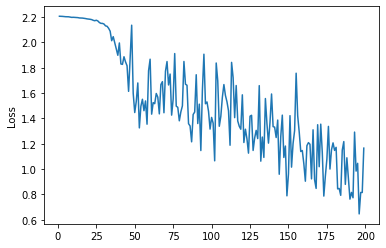

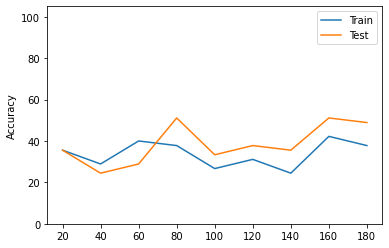

In [21]:
epochs = 200
n_way = 20
n_val = 45
batch_size = 35
epoch_step = 20

loss_list=[]
accuracy_list_val=[]
accuracy_list_train=[]

for epoch in range(1,epochs):
    #batch_x, batch_y = get_batch(batch_size, call_type="train")
    batch_x, batch_y = get_batch(batch_size)
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%epoch_step == 0:
        print("=============================================")
        accuracy_val = nway_one_shot_val(siamese_net, n_way, n_val)
        accuracy_list_val.append((epoch, accuracy_val))
        print('Accuracy on val as of', epoch, 'epochs:', accuracy_val)
        accuracy_train = nway_one_shot_train(siamese_net, n_way, n_val)
        accuracy_list_train.append((epoch, accuracy_train))
        print('Accuracy on train as of', epoch, 'epochs:', accuracy_train)
        print("=============================================")
        if(accuracy_val>95):
            print("Achieved more than 95% Accuracy")
            # break

plt.plot(*zip(*loss_list))
plt.ylabel('Loss')
plt.show()
plt.ylim(0,120)
plt.plot(*zip(*accuracy_list_train), label='Train')
plt.plot(*zip(*accuracy_list_val), label='Test')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim(0,105)
plt.show()

siamese_net.save_weights('/home/felipe/Documentos/tesis/permutacion2_modelo3d_tamaños_ajustados.h5')
#siamese_net.load_weights('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/ModeloEntrenado/Todas_25.h5')

In [23]:
#cargar modelo


In [4]:
indices_totales = x_train.shape[0]
lista_coordenadas = []
lista_clases = []
for i in range(indices_totales):
    lista_coordenadas.append(encoder.predict([x_train[i].reshape(1,300,150,1)])[0])
    lista_clases.append(y_train[i])
lista_coordenadas = np.asarray(lista_coordenadas)

indices_totales_val = x_val.shape[0]
lista_coordenadas_val = []
lista_clases_val = []
for i in range(indices_totales_val):
    lista_coordenadas_val.append(encoder.predict([x_val[i].reshape(1,300,150,1)])[0])
    lista_clases_val.append(y_val[i])
lista_coordenadas_val = np.asarray(lista_coordenadas_val)

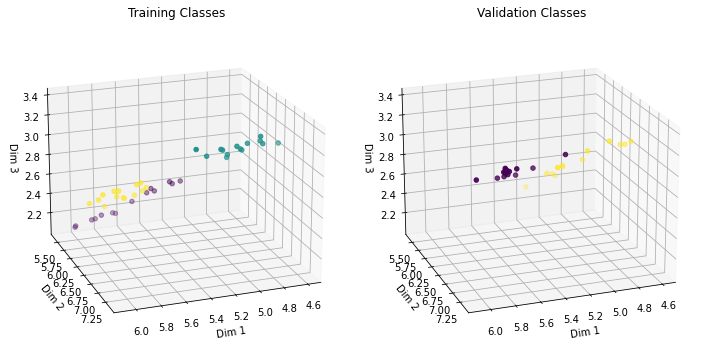

In [27]:
angulo_1 = 20
angulo_2 = 70

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(lista_coordenadas[:,0], lista_coordenadas[:,1], lista_coordenadas[:,2], c=lista_clases)
# ax.scatter(lista_coordenadas_val[:,0], lista_coordenadas_val[:,1], lista_coordenadas_val[:,2], c=lista_clases_val,marker="X")
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.title('Training Classes')
ax.view_init(angulo_1, angulo_2)

x_limites = ax.get_xlim()
y_limites = ax.get_ylim()
z_limites = ax.get_zlim()

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(lista_coordenadas_val[:,0], lista_coordenadas_val[:,1], lista_coordenadas_val[:,2], c=lista_clases_val)
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_zlabel('Dim 3')
ax1.set_xlim(x_limites)
ax1.set_ylim(y_limites)
ax1.set_zlim(z_limites)
plt.title('Validation Classes')
ax1.view_init(angulo_1, angulo_2)
plt.tight_layout()
plt.show()